## Working with a single subject Data

## Single-Subject EEG Preprocessing and Validation Notebook

This notebook demonstrates the exploratory preprocessing workflow applied to a
single EEG subject. The goal is to validate signal quality and preprocessing
choices before scaling the pipeline to multi-subject analysis.

Steps demonstrated:
1. Raw EEG inspection and sanity checks
2. Bandpass filtering
3. Artifact inspection and ICA-based cleaning
4. Baseline correction
5. Time–frequency (spectrogram) preparation

Note:
This notebook is intended for clarity and validation. The same preprocessing
logic is implemented in script form for batch processing of all subjects.


In [2]:
import mne 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path = r"C:\Users\iitj\Desktop\Noman\Noman\16Augb\raw_with_two_event_4_30.fif"
raw = mne.io.read_raw_fif(file_path, preload=True)

Opening raw data file C:\Users\iitj\Desktop\Noman\Noman\16Augb\raw_with_two_event_4_30.fif...
    Range : 0 ... 696319 =      0.000 ...  2719.996 secs
Ready.


C:\Users\iitj\AppData\Local\Temp\ipykernel_7624\1789297767.py:2: RuntimeWarning: This filename (C:\Users\iitj\Desktop\Noman\Noman\16Augb\raw_with_two_event_4_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 696319  =      0.000 ...  2719.996 secs...


In [4]:
print(raw)

<Raw | raw_with_two_event_4_30.fif, 14 x 696320 (2720.0 s), ~74.4 MB, data loaded>


Using matplotlib as 2D backend.


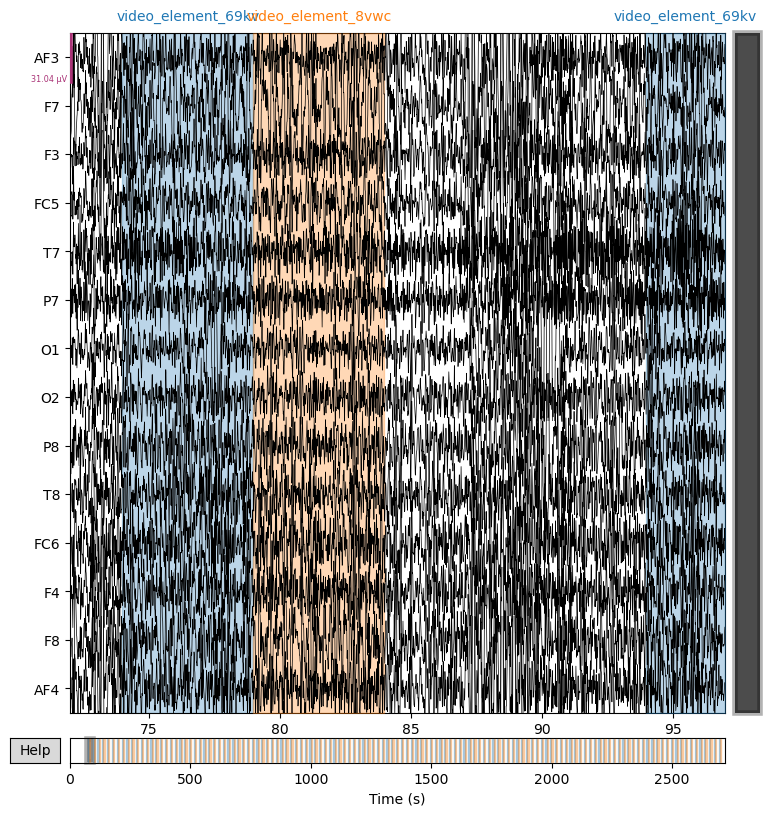

In [5]:

# Plot the data for the first clockwise occurence for 4 seconds with new raw channle object (only 14 channel information in it)
raw.plot(duration=25, start=72, scalings = "auto")
plt.show()


In [6]:
sampling_rate = raw.info['sfreq']
print(f"Sampling Rate: {sampling_rate} Hz")


Sampling Rate: 256.0 Hz


In [8]:
print(raw.info)

<Info | 10 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 file_id: 4 items (dict)
 highpass: 4.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2024-04-11 13:21:29 UTC
 meas_id: 4 items (dict)
 nchan: 14
 projs: []
 sfreq: 256.0 Hz
>


In [9]:
# Example: Compare calculated peak-to-peak amplitude with the visual inspection
channel_data = raw.get_data(picks=['AF3'])[0]  # Example channel AF3
manual_ptp = np.ptp(channel_data) * 1e6  # Peak-to-peak amplitude in microvolts
print(f"Manual PTP for AF3: {manual_ptp} µV")


Manual PTP for AF3: 1349.6542815119028 µV


In [10]:
# Check the raw data directly without any conversions
channel_data = raw.get_data(picks=['AF3'])[0]
print(f"Max Value in AF3 Channel: {channel_data.max() * 1e6} µV")
print(f"Min Value in AF3 Channel: {channel_data.min()* 1e6} µV")


Max Value in AF3 Channel: 697.708164807409 µV
Min Value in AF3 Channel: -651.9461167044938 µV


In [11]:
# Define a time segment to inspect (e.g., first 10 seconds)
start, stop = raw.time_as_index([72, 79])
segment_data = raw.get_data(picks=['AF3'], start=start, stop=stop)

# Calculate peak-to-peak amplitude for this segment
segment_ptp = np.ptp(segment_data) * 1e6  # Convert to µV
print(f"Segment PTP for AF3: {segment_ptp} µV")


Segment PTP for AF3: 234.63277466362342 µV


In [12]:
# Calculate and print peak-to-peak amplitudes for multiple channels
ptp_values = {}
for ch in raw.ch_names:
    data = raw.get_data(picks=[ch])[0]
    ptp = np.ptp(data[start:stop]) * 1e6  # Convert to µV
    ptp_values[ch] = ptp

print("Peak-to-Peak Amplitudes for Selected Channels:")
for ch, ptp in ptp_values.items():
    print(f"{ch}: {ptp} µV")


Peak-to-Peak Amplitudes for Selected Channels:
AF3: 234.63277466362342 µV
F7: 170.41215323843062 µV
F3: 86.85187276569195 µV
FC5: 108.99472908931784 µV
T7: 63.34160752885509 µV
P7: 58.33239083585795 µV
O1: 240.87839119601995 µV
O2: 55.640210121055134 µV
P8: 69.93076021899469 µV
T8: 60.67494359740522 µV
FC6: 81.05242523015477 µV
F4: 160.95996397780254 µV
F8: 141.81951701175421 µV
AF4: 224.39748863689601 µV


In [13]:
peak_to_peak_amplitudes = raw.get_data().ptp(axis=1)

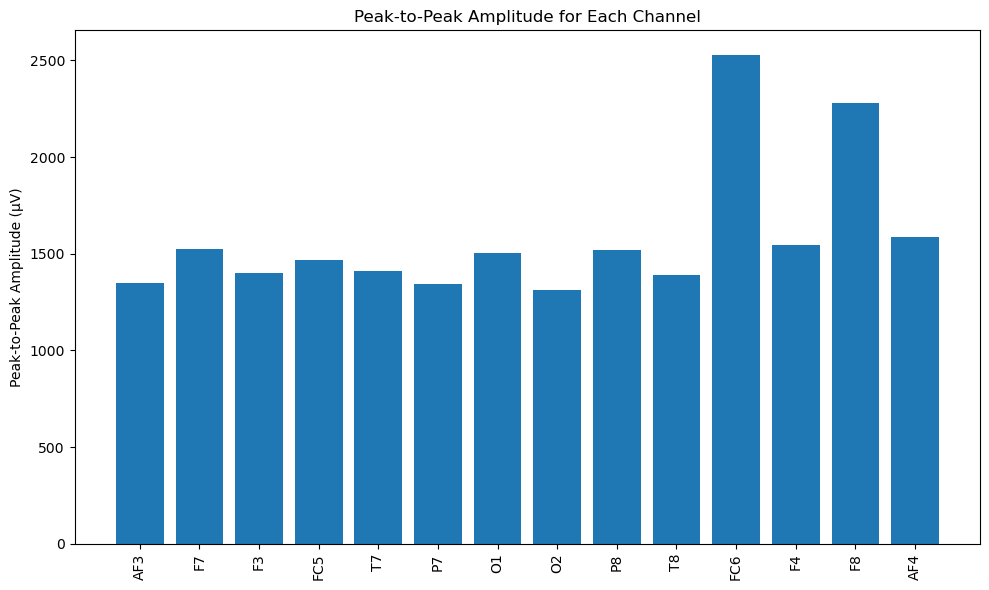

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get the channel names
channel_names = raw.ch_names

# Plot peak-to-peak amplitudes
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(channel_names)), peak_to_peak_amplitudes *1e6  )
plt.xticks(np.arange(len(channel_names)), channel_names, rotation=90)
plt.ylabel('Peak-to-Peak Amplitude (µV)')
plt.title('Peak-to-Peak Amplitude for Each Channel')
plt.tight_layout()
plt.show()

In [17]:
data, times = raw.get_data(return_times=True)
print(data.shape)
print(times.shape)

(14, 696320)
(696320,)


In [18]:
csv_path = r"C:\Users\iitj\Desktop\Noman\Noman\29 Meet\Data Collection Experiment Copy 1_EPOCX_218053_2024.04.11T13.21.29+05.30_intervalMarker_modified.csv"
events_df = pd.read_csv(csv_path)

In [26]:
print(raw.annotations)

<Annotations | 264 segments: video_element_69kv (132), video_element_8vwc ...>


In [32]:
print(raw.annotations.count())

{'video_element_69kv': 132, 'video_element_8vwc': 132}


In [34]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(20, 15))

fig = raw.plot(start=70, duration=6, show_scrollbars=False)

<Figure size 2000x1500 with 0 Axes>

In [36]:
print(len(raw.annotations))
print(set(raw.annotations.duration))
print(set(raw.annotations.description))
print(raw.annotations.onset[0])

264
{5.0}
{'video_element_69kv', 'video_element_8vwc'}
74.0


In [38]:
print(raw.annotations.onset[0])

74.0


In [40]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['video_element_69kv', 'video_element_8vwc']
{'video_element_69kv': 1, 'video_element_8vwc': 2}
[[18944     0     1]
 [20224     0     2]
 [24064     0     1]
 [25344     0     2]
 [29184     0     1]]


In [42]:
raw.plot(start=72, duration=5)
plt.show()

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


C:\Users\iitj\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


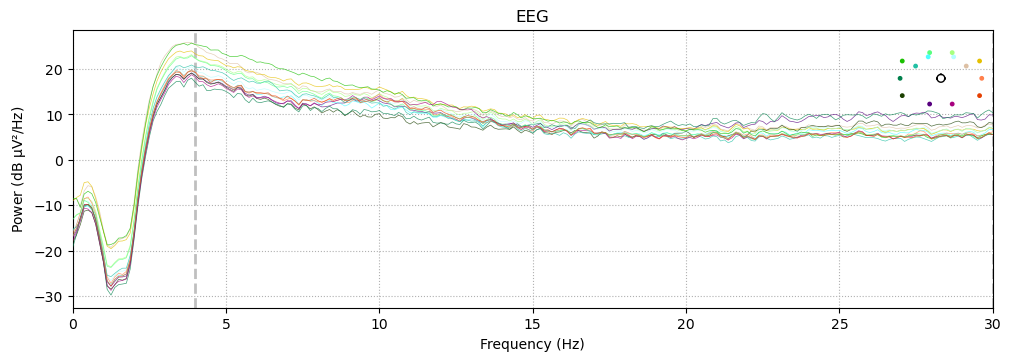

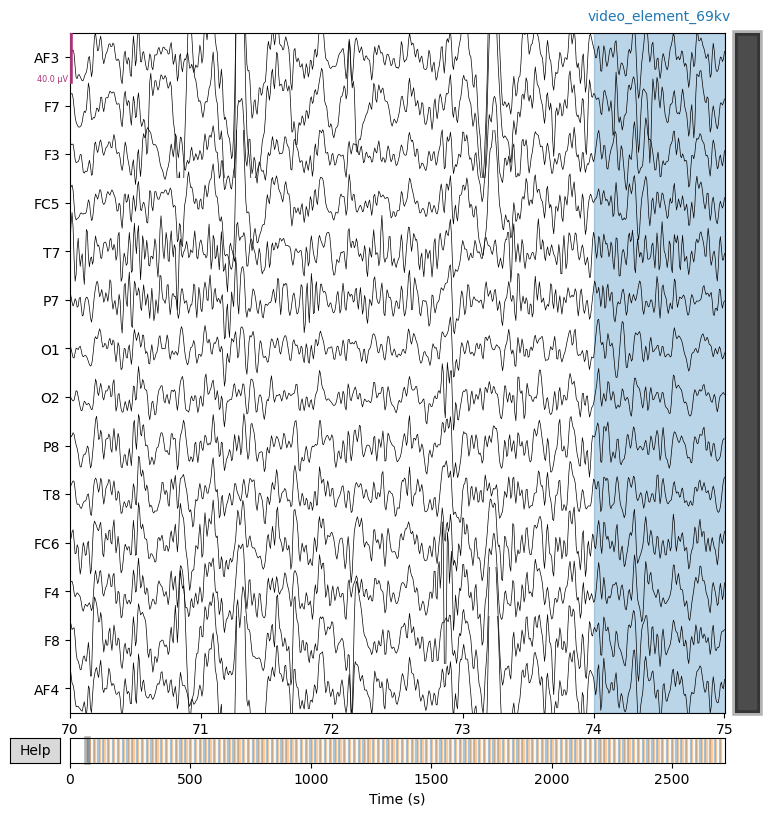

In [44]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=14, start = 70)
plt.show()

In [45]:
events, event_dict = mne.events_from_annotations(raw)

Used Annotations descriptions: ['video_element_69kv', 'video_element_8vwc']


In [48]:
num_events = len(events)
print(f"Number of events found: {num_events}")

Number of events found: 264


In [50]:
from mne.preprocessing import ICA
ica = mne.preprocessing.ICA(n_components = 14, random_state =0)

In [52]:
ica.fit(raw.copy().filter(4, 30))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 6.1s.


<ICA | raw data decomposition, method: fastica (fit in 32 iterations on 696320 samples), 14 ICA components (14 PCA components available), channel types: eeg, no sources marked for exclusion>

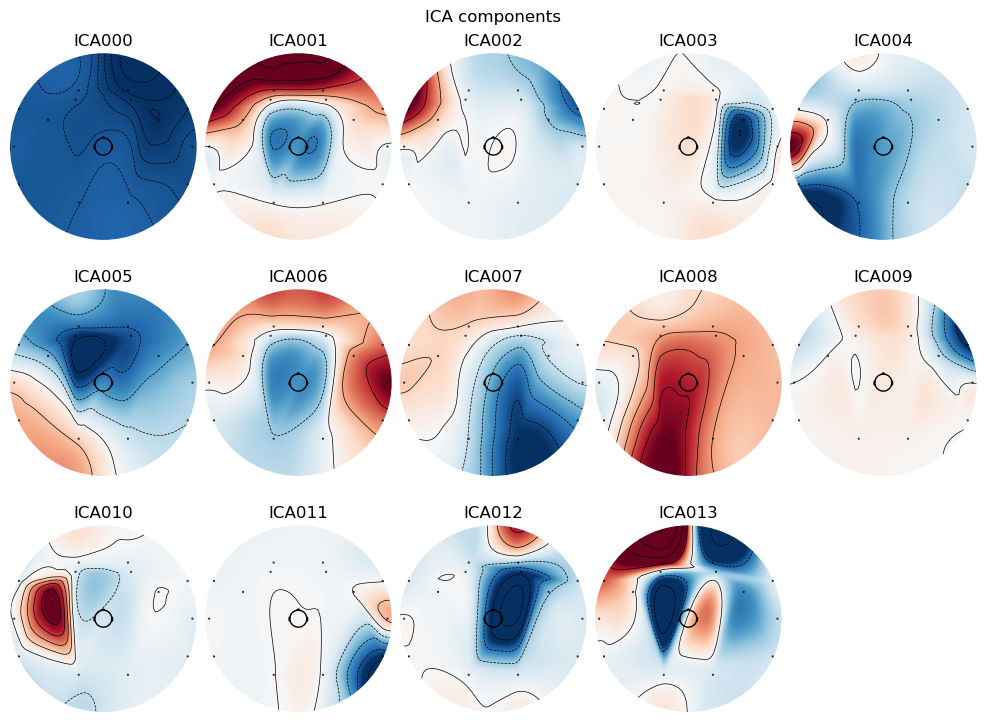

In [53]:
ica.plot_components();

In [54]:
ica.exclude = [0,1, 2]

In [55]:
raw.plot(duration = 5, start = 72)
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components


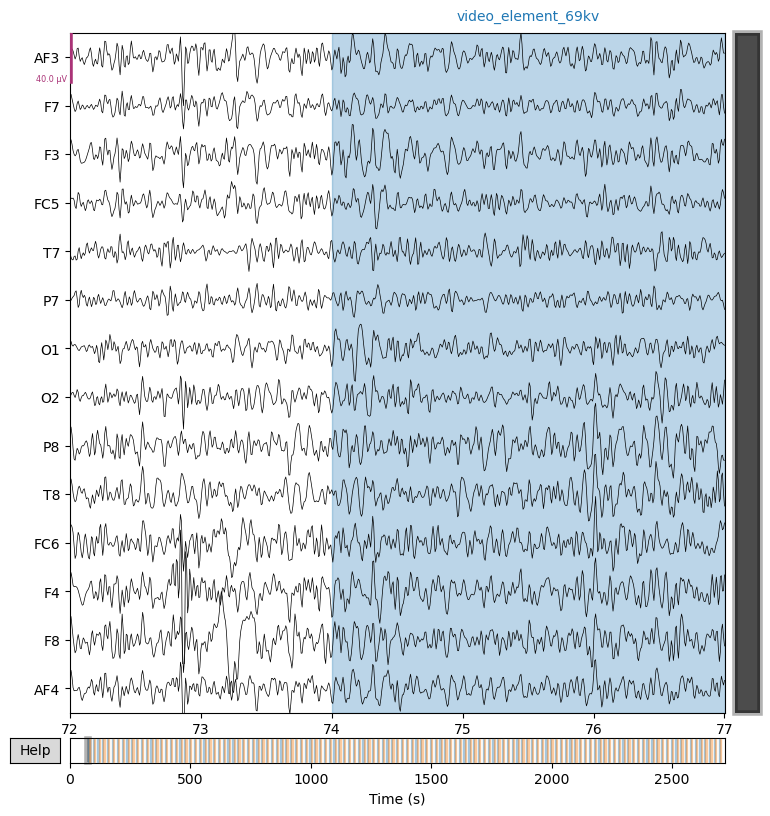

In [56]:
ica.apply(raw.copy(), exclude = ica.exclude).plot(duration = 5, start = 72)
plt.show()

In [62]:
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

In [64]:
event_ids = {'video_element_69kv': 1, 'video_element_8vwc' : 2}
epochs = mne.Epochs(raw, events, event_id = event_ids, preload = True, baseline = None)

Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 264 events and 180 original time points ...
0 bad epochs dropped


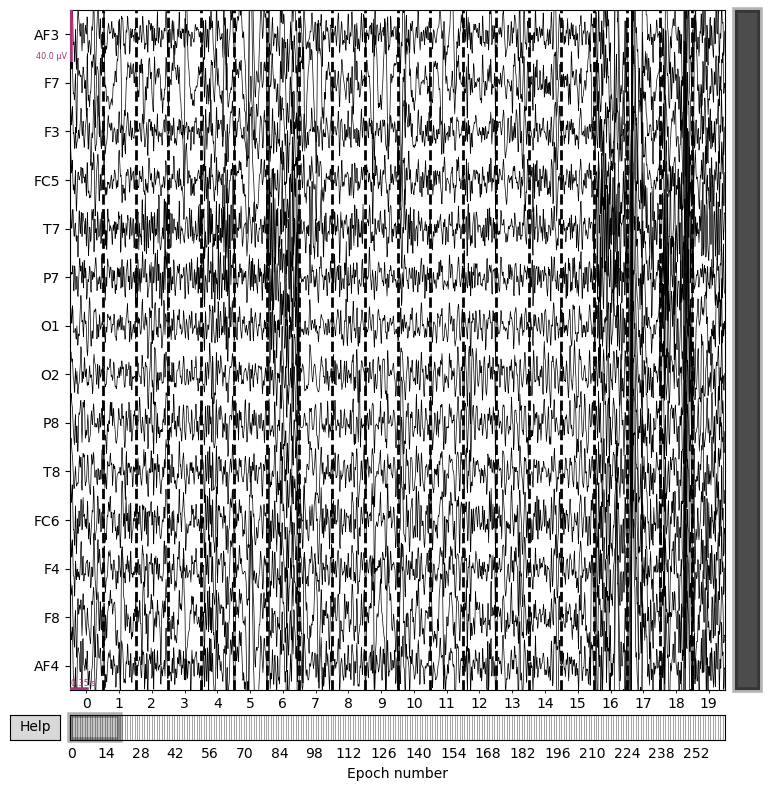

In [66]:
epochs.plot()
plt.show()

In [67]:
epochs = ica.apply(epochs, exclude = ica.exclude)

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated


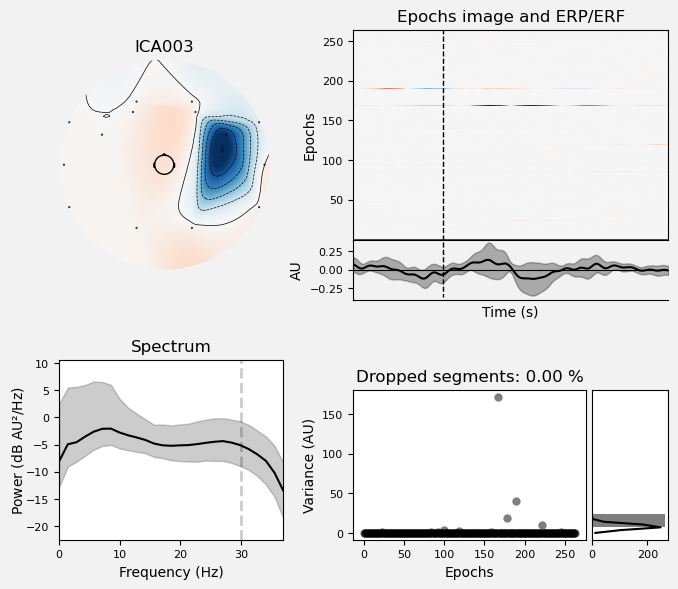

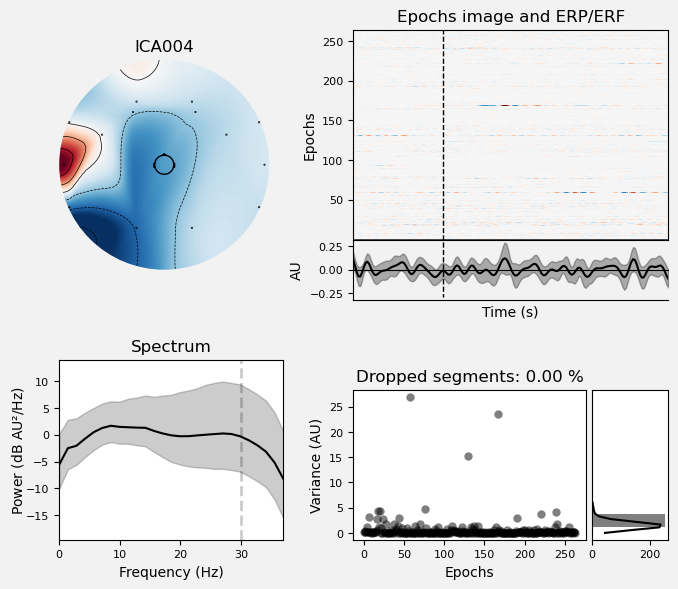

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [68]:
ica.plot_properties(epochs)

In [69]:
epochs = mne.Epochs(raw, events, event_id = event_ids, preload = True, tmin = -2, tmax = 5)
epochs = ica.apply(epochs, exclude = ica.exclude)

Not setting metadata
264 matching events found
Setting baseline interval to [-2.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 264 events and 1793 original time points ...
0 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components


C:\Users\iitj\AppData\Local\Temp\ipykernel_7624\4162055363.py:2: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs = ica.apply(epochs, exclude = ica.exclude)


In [70]:
epochs.apply_baseline(baseline=(-2, 0))

Applying baseline correction (mode: mean)


<Epochs |  264 events (all good), -2 – 5 s, baseline -2 – 0 s, ~50.6 MB, data loaded,
 'video_element_69kv': 132
 'video_element_8vwc': 132>

Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated


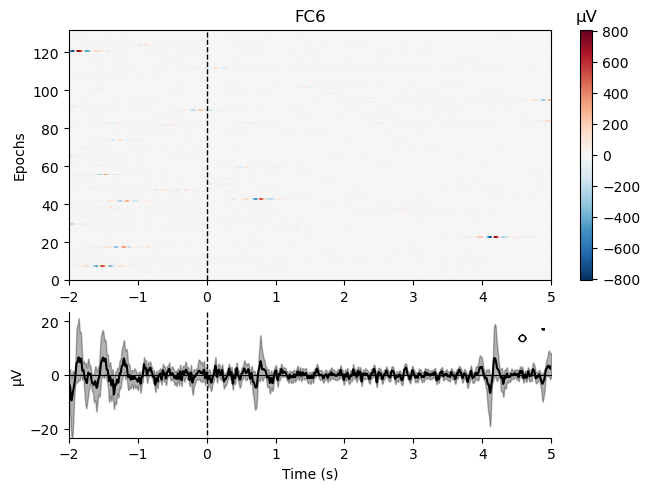

[<Figure size 640x480 with 4 Axes>]

In [71]:
epochs["video_element_69kv"].plot_image(picks = [10])


Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated


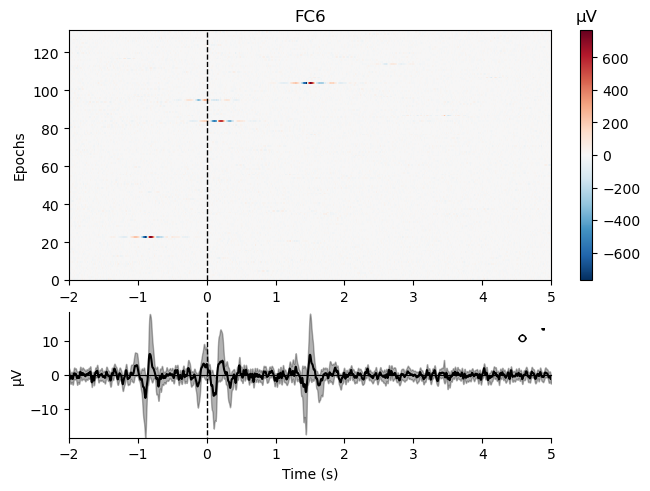

[<Figure size 640x480 with 4 Axes>]

In [72]:
epochs["video_element_8vwc"].plot_image(picks = [10])

In [86]:
clockwise_epoch = epochs["video_element_69kv"]
anticlockwise_epochs = epochs["video_element_8vwc"]

In [88]:
clockwise_epoch

<Epochs |  132 events (all good), -2 – 5 s, baseline -2 – 0 s, ~25.3 MB, data loaded,
 'video_element_69kv': 132>

In [90]:
anticlockwise_epochs

<Epochs |  132 events (all good), -2 – 5 s, baseline -2 – 0 s, ~25.3 MB, data loaded,
 'video_element_8vwc': 132>

In [73]:
X = epochs.get_data(copy = True)

In [74]:
y = epochs.events[:, -1]

In [75]:
rank_dict = {
    'AF3': 1,
    'F7': 1,
    'F3': 1,
    'FC5': 1,
    'T7': 1,
    'P7': 1,
    'O1': 1,
    'O2': 1,
    'P8': 1,
    'T8': 1,
    'FC6': 1,
    'F4': 1,
    'F8': 1,
    'AF4': 1
}

In [46]:
# csp= mne.decoding.CSP(n_components=6, reg=0.1, log=True, norm_trace=False, transform_into = 'average_power')

In [47]:
csp = mne.decoding.CSP(n_components=14, reg=0.1, log=None, norm_trace=False, transform_into='csp_space', rank = rank_dict)
csp.fit(X, y)


Reducing data rank from 14 -> 14
Estimating class=1 covariance using SHRINKAGE
Done.
Estimating class=2 covariance using SHRINKAGE
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 14,
 'norm_trace': False,
 'rank': {'AF3': 1,
          'AF4': 1,
          'F3': 1,
          'F4': 1,
          'F7': 1,
          'F8': 1,
          'FC5': 1,
          'FC6': 1,
          'O1': 1,
          'O2': 1,
          'P7': 1,
          'P8': 1,
          'T7': 1,
          'T8': 1},
 'reg': 0.1,
 'transform_into': 'csp_space'})

In [48]:
csp.fit(X, y)

Reducing data rank from 14 -> 14
Estimating class=1 covariance using SHRINKAGE
Done.
Estimating class=2 covariance using SHRINKAGE
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 14,
 'norm_trace': False,
 'rank': {'AF3': 1,
          'AF4': 1,
          'F3': 1,
          'F4': 1,
          'F7': 1,
          'F8': 1,
          'FC5': 1,
          'FC6': 1,
          'O1': 1,
          'O2': 1,
          'P7': 1,
          'P8': 1,
          'T7': 1,
          'T8': 1},
 'reg': 0.1,
 'transform_into': 'csp_space'})

In [49]:
X_transformed = csp.transform(X)


In [50]:
X_transformed.shape

(264, 14, 1793)

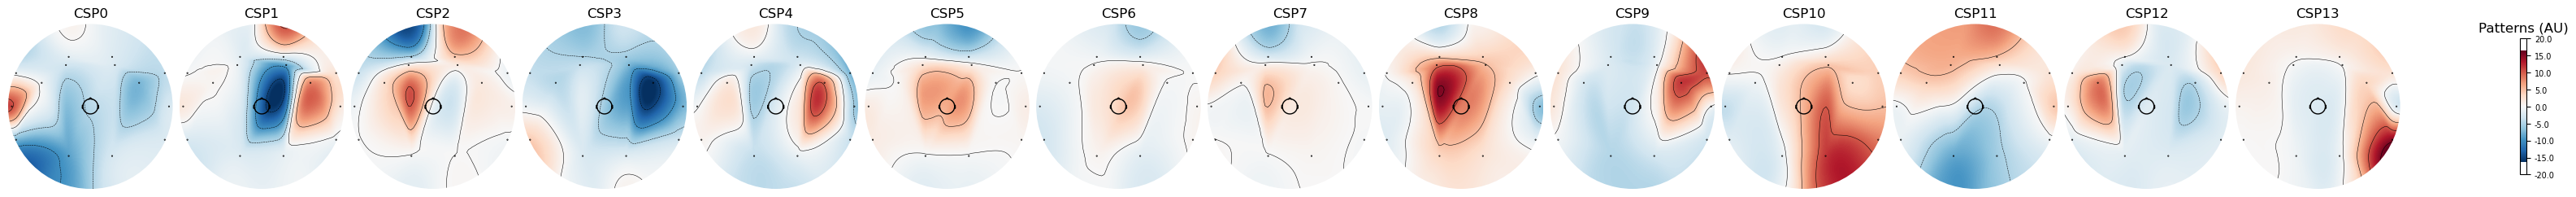

In [51]:
csp.plot_patterns(epochs.info, units="Patterns (AU)", size = 1.5)
plt.show()

In [52]:
filters = csp.filters_

In [59]:
filters.shape

(14, 14)

In [62]:
events=epochs.events
print(events)

[[ 18944      0      1]
 [ 20224      0      2]
 [ 24064      0      1]
 [ 25344      0      2]
 [ 29184      0      1]
 [ 30464      0      2]
 [ 34304      0      1]
 [ 35584      0      2]
 [ 39424      0      1]
 [ 40704      0      2]
 [ 44544      0      1]
 [ 45824      0      2]
 [ 49664      0      1]
 [ 50944      0      2]
 [ 54784      0      1]
 [ 56064      0      2]
 [ 59904      0      1]
 [ 61184      0      2]
 [ 65024      0      1]
 [ 66304      0      2]
 [ 70144      0      1]
 [ 71424      0      2]
 [ 75264      0      1]
 [ 76544      0      2]
 [ 80384      0      1]
 [ 81664      0      2]
 [ 85504      0      1]
 [ 86784      0      2]
 [ 90624      0      1]
 [ 91904      0      2]
 [ 95744      0      1]
 [ 97024      0      2]
 [100864      0      1]
 [102144      0      2]
 [105984      0      1]
 [107264      0      2]
 [111104      0      1]
 [112384      0      2]
 [116224      0      1]
 [117504      0      2]
 [121344      0      1]
 [122624      0 

In [68]:
event_ids

{'video_element_69kv': 1, 'video_element_8vwc': 2}

In [69]:
# Create a new EpochsArray object using the CSP-transformed data
epochs_csp = mne.EpochsArray(X_transformed, epochs.info, events=epochs.events, event_id=event_ids, tmin=epochs.tmin)
epochs_csp.apply_baseline(baseline=(-2, 0))

Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)


<EpochsArray |  264 events (all good), -2 – 5 s, baseline -2 – 0 s, ~50.6 MB, data loaded,
 'video_element_69kv': 132
 'video_element_8vwc': 132>

In [70]:
X_csp = epochs_csp.get_data(copy = True)

In [75]:
len(X_csp)

264

C:\Users\iitj\AppData\Local\Temp\ipykernel_8224\125612000.py:5: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  tfr = mne.time_frequency.tfr_array_morlet(


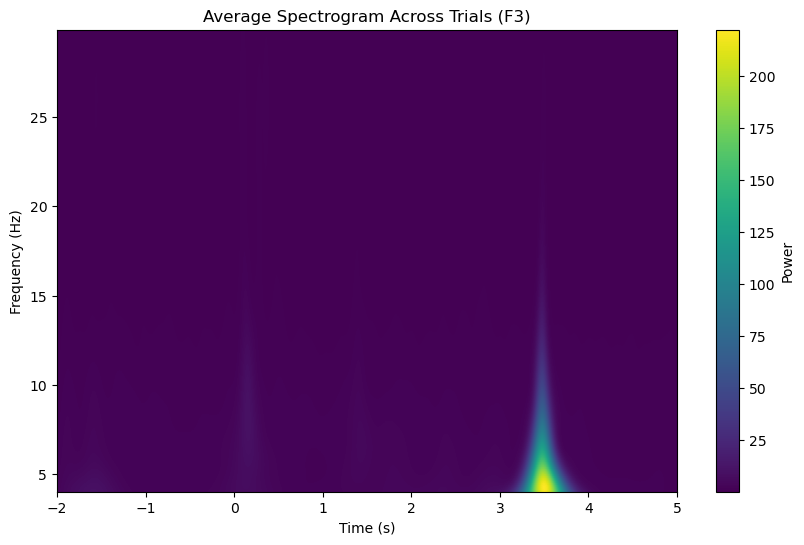

In [76]:
frequencies = np.arange(4, 30, 0.1)  # Frequencies from 7Hz to 30Hz in steps of 3Hz

n_cycles = 5
# Compute TFR using Morlet wavelets
tfr = mne.time_frequency.tfr_array_morlet(
    X_csp, sfreq=256, freqs=frequencies,
    n_cycles=n_cycles, output='power'
)

# Average TFR across all trials
tfr_mean = np.mean(tfr, axis=0)  # Shape will be (n_channels, n_freqs, n_times)

# Plotting average spectrogram for the first channel
plt.figure(figsize=(10, 6))
plt.imshow(
    tfr_mean[2, :, :], aspect='auto', origin='lower',
    extent=[epochs_csp.times[0], epochs_csp.times[-1], frequencies[0], frequencies[-1]]
)
plt.colorbar(label='Power')
plt.title('Average Spectrogram Across Trials (F3)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

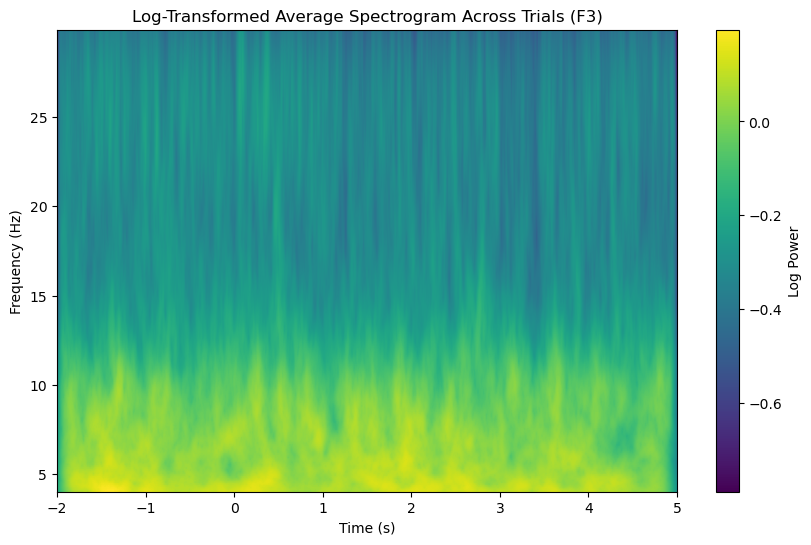

In [77]:
# Apply log transformation
tfr_log = np.log10(tfr)

# Average TFR across all trials after normalization
tfr_mean = np.mean(tfr_log, axis=0)

# Plotting log-transformed average spectrogram for the first channel
plt.figure(figsize=(10, 6))
plt.imshow(
    tfr_mean[2, :, :], aspect='auto', origin='lower',
    extent=[epochs_csp.times[0], epochs_csp.times[-1], frequencies[0], frequencies[-1]]
)
plt.colorbar(label='Log Power')
plt.title('Log-Transformed Average Spectrogram Across Trials (F3)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


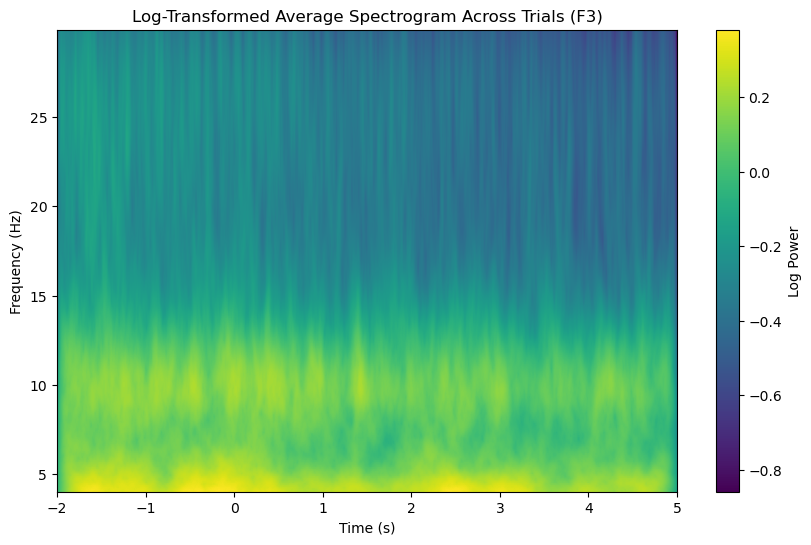

In [78]:
# Apply log transformation
tfr_log = np.log10(tfr)

# Average TFR across all trials after normalization
tfr_mean = np.mean(tfr_log, axis=0)

# Plotting log-transformed average spectrogram for the first channel
plt.figure(figsize=(10, 6))
plt.imshow(
    tfr_mean[4, :, :], aspect='auto', origin='lower',
    extent=[epochs_csp.times[0], epochs_csp.times[-1], frequencies[0], frequencies[-1]]
)
plt.colorbar(label='Log Power')
plt.title('Log-Transformed Average Spectrogram Across Trials (F3)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


In [80]:
import mne
import numpy as np
import matplotlib.pyplot as plt

frequencies = np.arange(4, 30, 0.1)  # Frequencies from 4Hz to 30Hz in steps of 0.1Hz
n_cycles = 5

# Compute TFR using Morlet wavelets
tfr = mne.time_frequency.tfr_array_morlet(
    X_csp, sfreq=256, freqs=frequencies,
    n_cycles=n_cycles, output='power'
)

# Plot spectrograms for each trial
n_trials = tfr.shape[0]
n_channels = tfr.shape[1]


C:\Users\iitj\AppData\Local\Temp\ipykernel_8224\2345366341.py:9: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  tfr = mne.time_frequency.tfr_array_morlet(


In [81]:
tfr_log = np.log10(tfr)

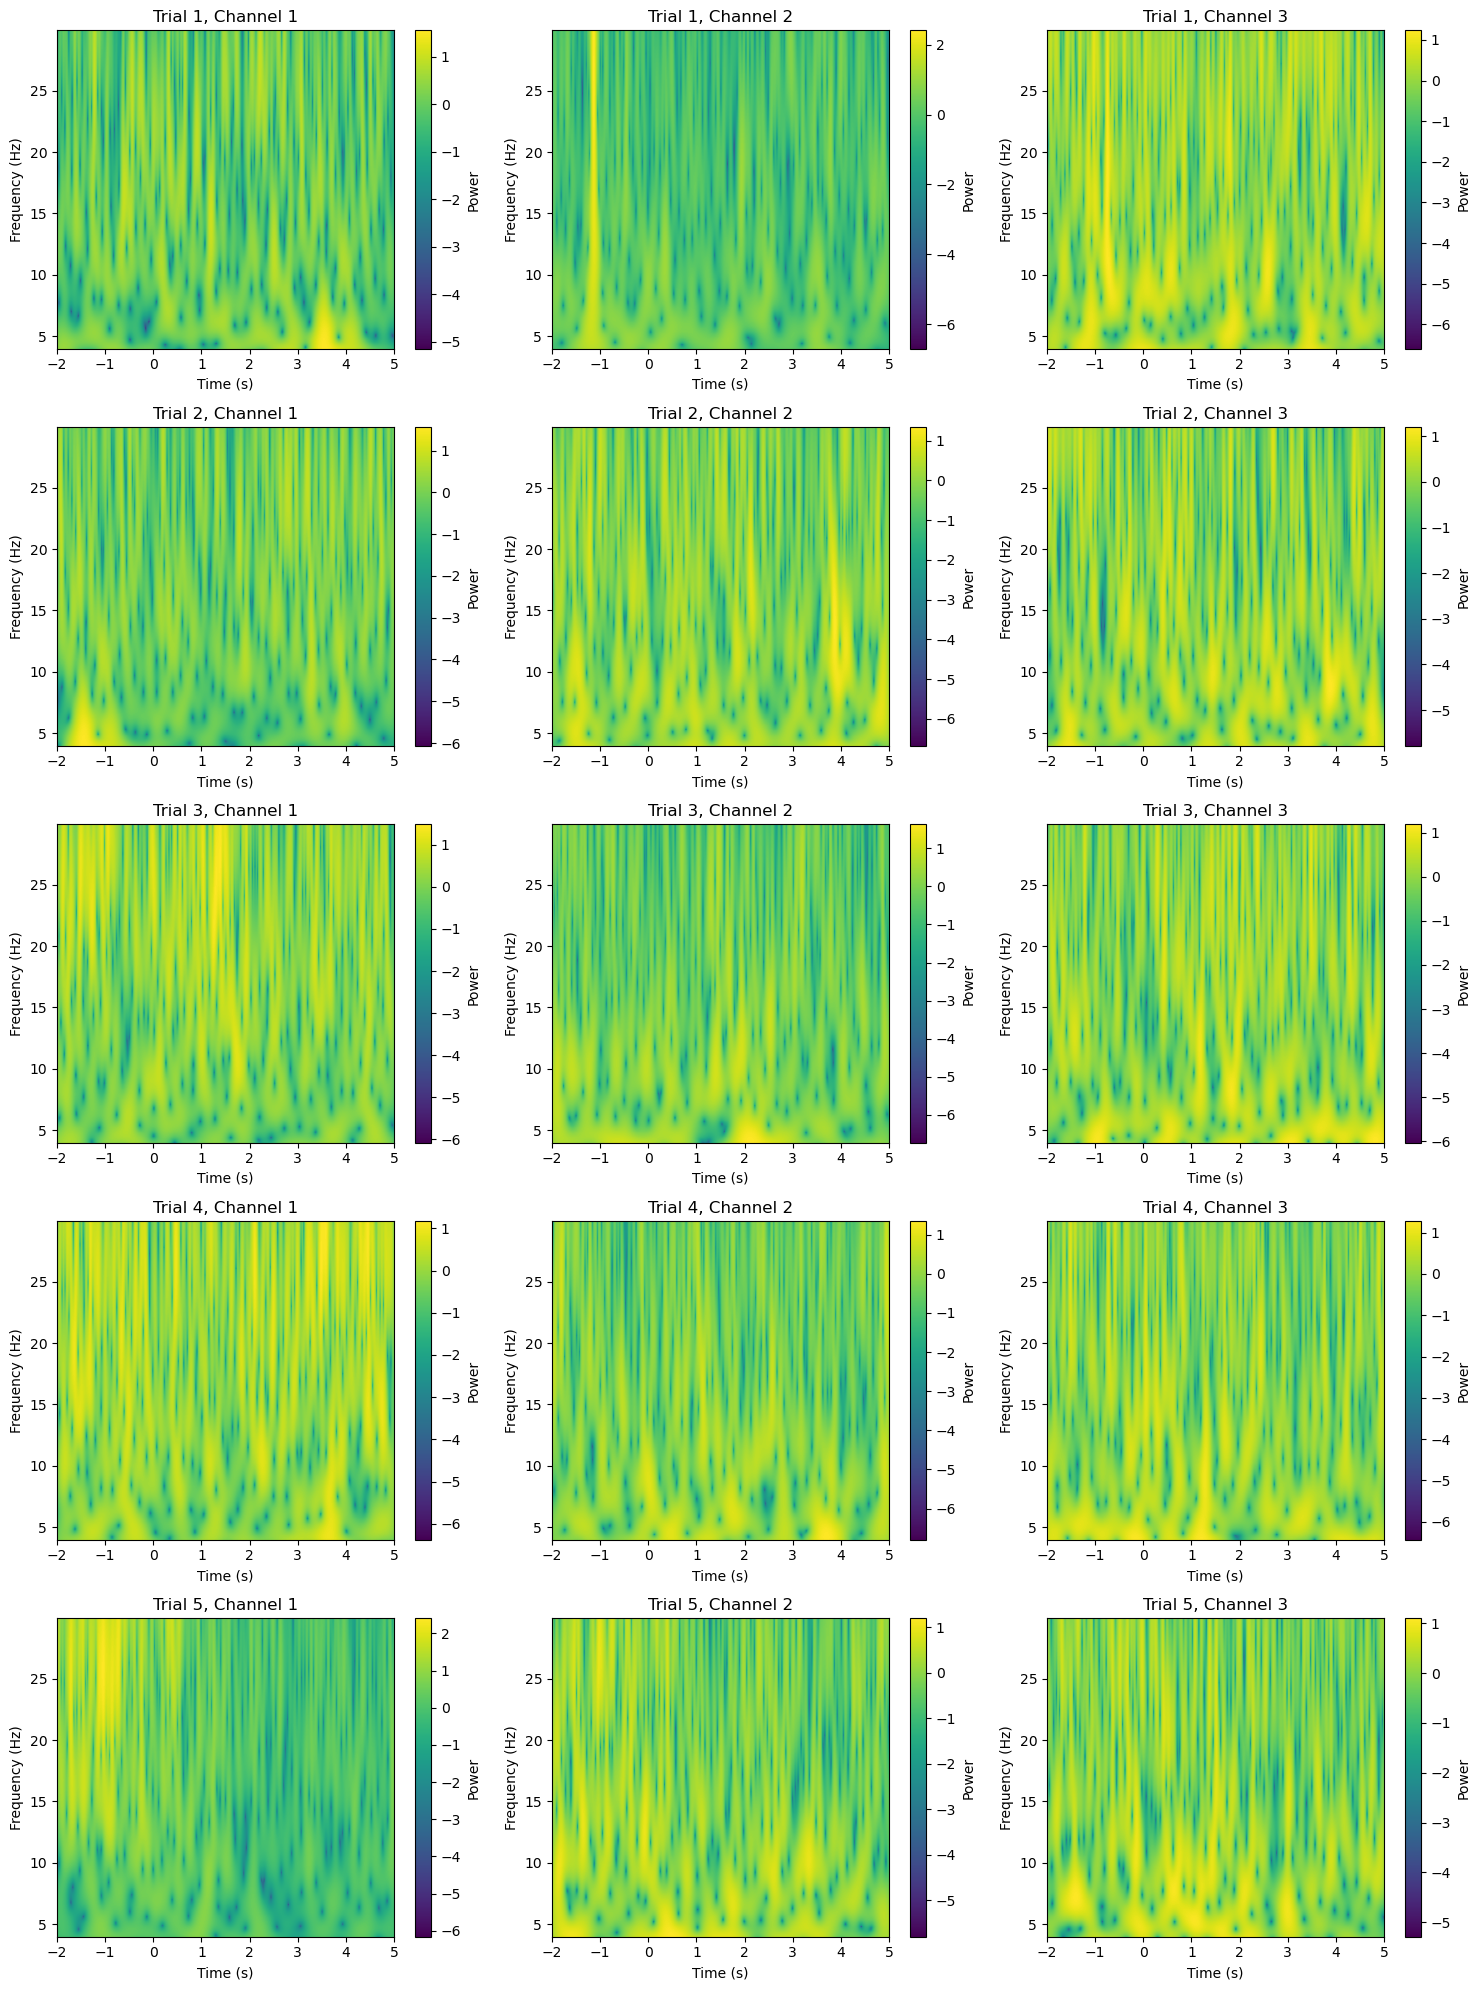

In [82]:

trials_to_plot = min(n_trials, 5)  # Plot first 5 trials or all if less than 5
channels_to_plot = min(n_channels, 3)  # Plot first 3 channels or all if less than 3

fig, axes = plt.subplots(trials_to_plot, channels_to_plot, 
                         figsize=(5*channels_to_plot, 4*trials_to_plot), 
                         squeeze=False)

for trial in range(trials_to_plot):
    for channel in range(channels_to_plot):
        ax = axes[trial, channel]
        im = ax.imshow(
            tfr_log[trial, channel, :, :], aspect='auto', origin='lower',
            extent=[epochs_csp.times[0], epochs_csp.times[-1], frequencies[0], frequencies[-1]]
        )
        ax.set_title(f'Trial {trial+1}, Channel {channel+1}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        plt.colorbar(im, ax=ax, label='Power')

plt.tight_layout()
plt.show()